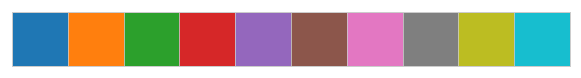

In [166]:
import numpy as np
import pandas as pd
import json
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import Ridge
from scipy.sparse import csr_matrix, hstack
from scipy.stats import probplot
import pickle
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
get_ipython().run_line_magic('matplotlib', 'inline')
import seaborn as sns
import gc
import warnings
warnings.filterwarnings('ignore')
import time
from html.parser import HTMLParser
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder, StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from nltk.stem import PorterStemmer
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, StratifiedKFold
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn import decomposition
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import train_test_split

from sklearn.linear_model import Ridge

from sklearn.cluster import KMeans

color = sns.color_palette()
sns.set_style("whitegrid")
sns.set_context("paper")
sns.palplot(color)

import os
PATH = "../../data"

In [2]:
def read_json_line(line=None):
    result = None
    try:
        result = json.loads(line)
    except Exception as e:
        # Find the offending character index:
        idx_to_replace = int(str(e).split(' ')[-1].replace(')',''))
        # Remove the offending character:
        new_line = list(line)
        new_line[idx_to_replace] = ' '
        new_line = ''.join(new_line)
        return read_json_line(line=new_line)
    return result


class MLStripper(HTMLParser):
    def __init__(self):
        self.reset()
        self.strict = False
        self.convert_charrefs= True
        self.fed = []
    def handle_data(self, d):
        self.fed.append(d)
    def get_data(self):
        return ''.join(self.fed)

def strip_tags(html):
    s = MLStripper()
    s.feed(html)
    return s.get_data()

In [85]:
def extract_features(path_to_data):

    content_list = []
    published_list = []
    title_list = []
    author_list = []
    domain_list = []
    tags_list = []
    url_list = []

    with open(path_to_data, encoding='utf-8') as inp_json_file:
        for line in inp_json_file:
            json_data = read_json_line(line)
#             content = json_data['content'].replace('\n', ' ').replace('\r', ' ') # ORIG
            content = json_data['content'].replace('\n', ' \n ').replace('\r', ' \n ') # keep newline
            content_no_html_tags = strip_tags(content)
            content_list.append(content_no_html_tags)
            published = json_data['published']['$date']
            published_list.append(published)
            title = json_data['meta_tags']['title'].split('\u2013')[0].strip() #'Medium Terms of Service – Medium Policy – Medium'
            title_list.append(title)
            author = json_data['meta_tags']['author'].strip()
            author_list.append(author)
            domain = json_data['domain']
            domain_list.append(domain)
            url = json_data['url']
            url_list.append(url)

            tags_str = []
            soup = BeautifulSoup(content, 'lxml')
            try:
                tag_block = soup.find('ul', class_='tags')
                tags = tag_block.find_all('a')
                for tag in tags:
                    tags_str.append(tag.text.translate({ord(' '):None, ord('-'):None}))
                tags = ' '.join(tags_str)
            except Exception:
                tags = 'None'
            tags_list.append(tags)

    return content_list, published_list, title_list, author_list, domain_list, tags_list, url_list


# ## 1.2. Data extraction

# [ ]:


content_list, published_list, title_list, author_list, domain_list, tags_list, url_list = \
    extract_features(os.path.join(PATH, 'train.json'))

train = pd.DataFrame()
train['content'] = content_list
train['published'] = pd.to_datetime(published_list, format='%Y-%m-%dT%H:%M:%S.%fZ')
train['title'] = title_list
train['author'] = author_list
train['domain'] = domain_list
train['tags'] = tags_list
# train['length'] = train['content'].apply(len)
train['url'] = url_list

content_list, published_list, title_list, author_list, domain_list, tags_list, url_list = \
    extract_features(os.path.join(PATH, 'test.json'))

test = pd.DataFrame()
test['content'] = content_list
test['published'] = pd.to_datetime(published_list, format='%Y-%m-%dT%H:%M:%S.%fZ')
test['title'] = title_list
test['author'] = author_list
test['domain'] = domain_list
test['tags'] = tags_list
# test['length'] = test['content'].apply(len)
test['url'] = url_list


# [ ]:


del content_list, published_list, title_list, author_list, domain_list, tags_list, url_list
gc.collect()


train['week_day'] = train['published'].apply(lambda x: x.dayofweek)
train['year'] = train['published'].apply(lambda x: x.year)
train['month'] = train['published'].apply(lambda x: x.month)
train['hour'] = train['published'].apply(lambda x: x.hour)
train['length'] = train['content'].apply(len)
#train['number_of_tags'] = train['tags'].apply(lambda x: len(x.split()))

test['week_day'] = test['published'].apply(lambda x: x.dayofweek)
test['year'] = test['published'].apply(lambda x: x.year)
test['month'] = test['published'].apply(lambda x: x.month)
test['hour'] = test['published'].apply(lambda x: x.hour)
test['length'] = test['content'].apply(len)
#test['number_of_tags'] = test['tags'].apply(lambda x: len(x.split()))
# [ ]:


train['target'] = pd.read_csv(os.path.join(
        PATH,
        'train_log1p_recommends.csv'),
    index_col='id').values


# [ ]:


train.tail()


# [ ]:


train.describe()


train.to_csv("mediumPopularity.csv.gz", index=False, compression="gzip")
test.to_csv("mediumPopularity_test.csv.gz", index=False, compression="gzip")

In [86]:
top = train.sort_values(by='target', ascending=False).reset_index(drop=True)
print(top.loc[0, 'url'])
print(top.loc[1, 'url'])

https://medium.com/personal-growth/13-things-you-need-to-give-up-if-you-want-to-be-successful-44b5b9b06a26
https://medium.com/@dinachka82/about-your-poem-1f26a7585a6f


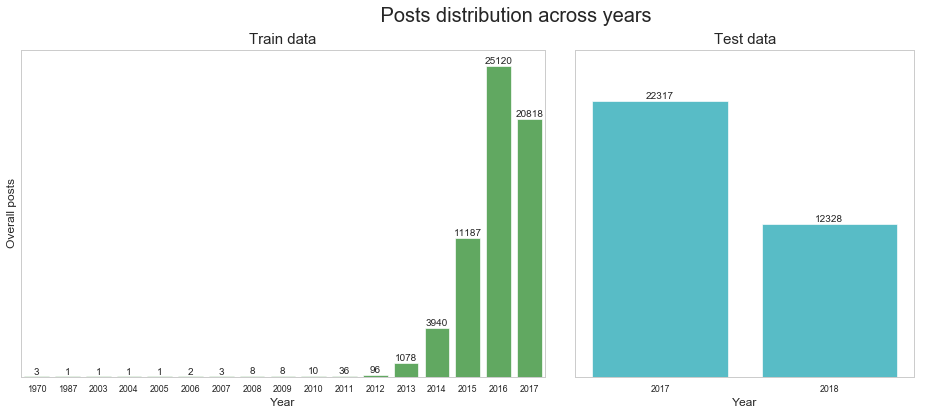

In [87]:
plt.figure(figsize=(16,6))
plt.suptitle("                       Posts distribution across years",fontsize=20)

ax1 = plt.subplot2grid((1,5),(0,0), colspan=3)
ax1 = sns.countplot(x='year', data=train, alpha=0.8, color=color[2])
plt.ylabel('Overall posts', fontsize=12)
plt.xlabel('Year', fontsize=12)
plt.title('Train data', fontsize=15)
plt.grid(False)

for p in ax1.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax1.annotate('{}'.format(p.get_height()), (x.mean(), y), ha='center', va='bottom')
    
ax2 = plt.subplot2grid((1,5),(0,3), colspan=2, sharey=ax1)
ax2 = sns.countplot(x='year', data=test, alpha=0.8, color=color[9])
plt.xlabel('Year', fontsize=12)
plt.title('Test data', fontsize=15)
plt.yticks([])
plt.ylabel('')

for p in ax2.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax2.annotate('{}'.format(p.get_height()), (x.mean(), y), ha='center', va='bottom')

In [88]:
train = train[train.year >= 2015]

In [89]:
train_df = train
test_df = test

all_zero_mae = 4.33328

In [90]:
def write_submission_file(prediction,
                          filename,
                          path_to_sample=os.path.join(
                                  PATH,
                                  'sample_submission.csv')):
    submission = pd.read_csv(path_to_sample, index_col='id')

    submission['log_recommends'] = prediction
    submission.to_csv(filename)

In [91]:
# Special transformer to save output shape
class ShapeSaver(BaseEstimator, TransformerMixin):
    def transform(self, X):
        self.shape = X.shape
        return X

    def fit(self, X, y=None, **fit_params):
        return self

In [92]:
# Run preprocessing on full data
x_train_new = train_df.iloc[:, :-1]
x_test_new = test_df.iloc[:, :].copy()
experiments = {}

with open('medium_experiments.pickle', 'rb') as f:
    experiments = pickle.load(f)

In [93]:
stemmer = PorterStemmer()
wordnet_lemmatizer = WordNetLemmatizer()

In [154]:
def extract_content_as_string(X):
    return X['content']


def extract_content_length(X):
    return pd.DataFrame(X['content'].str.len())


def extract_author_as_string(X):
    return X['author']


def extract_tags_as_string(X):
    return X['tags']


def extract_title_as_string(X):
    return X['title']

def extract_domain_as_string(X):
    return X['domain']


def feature_weekday(X):
    return X[['week_day']]


def feature_hour(X):
    return X[['hour']]


def feature_month(X):
    return X[['month']]


# yearfeature from A4
def feature_year(X):
    return X[['year']]


# Month Q
def feature_month_q1(X):
    return pd.DataFrame(X['published'].dt.month.isin([1, 2, 3]))


# Month Q
def feature_month_q2(X):
    return pd.DataFrame(X['published'].dt.month.isin([4, 5, 6]))


# Month Q
def feature_month_q3(X):
    return pd.DataFrame(X['published'].dt.month.isin([7, 8, 9]))


# Month Q
def feature_month_q4(X):
    return pd.DataFrame(X['published'].dt.month.isin([10, 11, 12]))


# kmeans = KMeans(n_clusters=10, random_state=17).fit(X_train_new)
def kmeans_class(X):
    pd.DataFrame(kmeans.predict(X))
    
    
def stem_tokenize(text):
    tokens = nltk.word_tokenize(text)
    stems = []
    for item in tokens:
        stems.append(PorterStemmer().stem(item))
    return stems


class StemmedCountVectorizer(TfidfVectorizer):
    def build_analyzer(self):
        analyzer = super(StemmedCountVectorizer, self).build_analyzer()
        return lambda doc: ([stemmer.stem(w) for w in analyzer(doc)])


class TfidfLeammatizerVectorizer(TfidfVectorizer):
    def build_analyzer(self):
        analyzer = super(TfidfLeammatizerVectorizer, self).build_analyzer()
        return lambda doc: ([wordnet_lemmatizer.lemmatize(w) for w in analyzer(doc)])

In [156]:
# --------------------------------------------------------------------------
transform_pipeline = Pipeline([
    ('features', FeatureUnion([
        # List of features goes here:
        ('author_tfidf', Pipeline([
            ('extract', FunctionTransformer(extract_author_as_string, validate=False)),
            ('count', TfidfVectorizer(ngram_range=(2, 2), max_features=10000)),
#            ("tfidf", TfidfTransformer()),
            ('shape', ShapeSaver())
        ])),

        ('domain_tfidf', Pipeline([
            ('extract', FunctionTransformer(extract_domain_as_string, validate=False)),
            ('count', TfidfVectorizer(max_features=10000)),
#            ("tfidf", TfidfTransformer()),
            ('shape', ShapeSaver())
        ])),

       ('weekday_cat', Pipeline([
           ('extract', FunctionTransformer(feature_weekday, validate=False)),
           ('ohe', OneHotEncoder()),
           ('shape', ShapeSaver())
       ])),

       ('month_cat', Pipeline([
           ('extract', FunctionTransformer(feature_month, validate=False)),
           ('ohe', OneHotEncoder()),
           ('shape', ShapeSaver())
        ])),

       ('hour_val', Pipeline([
           ('extract', FunctionTransformer(feature_hour, validate=False)),
#            ('scale', StandardScaler()),
           ('ohe', OneHotEncoder()),
           ('shape', ShapeSaver())
        ])),
        
       ('kmeans_class', Pipeline([
           ('extract', FunctionTransformer(kmeans_class, validate=False)),
           ('ohe', OneHotEncoder()),
           ('shape', ShapeSaver())
        ])),
        
#        ('mon_q1', Pipeline([
#            ('extract', FunctionTransformer(feature_month_q1, validate=False)),
#            ('shape', ShapeSaver())
#         ])),
#        ('mon_q2', Pipeline([
#            ('extract', FunctionTransformer(feature_month_q2, validate=False)),
#            ('shape', ShapeSaver())
#         ])),
#        ('mon_q3', Pipeline([
#            ('extract', FunctionTransformer(feature_month_q3, validate=False)),
#            ('shape', ShapeSaver())
#         ])),
#        ('mon_q4', Pipeline([
#            ('extract', FunctionTransformer(feature_month_q4, validate=False)),
#            ('shape', ShapeSaver())
#         ])),

#        ('year', Pipeline([
#            ('extract', FunctionTransformer(feature_year, validate=False)),
#            ('ohe', OneHotEncoder()),
#            ('shape', ShapeSaver())
#         ])),

#        ('tags_tfidf', Pipeline([
#            ('extract', FunctionTransformer(extract_tags_as_string, validate=False)),
#            ('count', TfidfVectorizer(max_features=10000)),
##            ("tfidf", TfidfTransformer()),
#            ('shape', ShapeSaver())
#        ])),
#
#        ('title_tfidf', Pipeline([
#            ('extract', FunctionTransformer(extract_title_as_string, validate=False)),
#            ('count', TfidfVectorizer(max_features=10000)),
##            ("tfidf", TfidfTransformer()),
#            ('shape', ShapeSaver())
#        ])),

#        ('content_length', Pipeline([
#            ('extract', FunctionTransformer(extract_content_length, validate=False)),
#            ('scale', StandardScaler()),
#            ('shape', ShapeSaver())
#        ])),

#        ('content_tfidf', Pipeline([
#            ('extract', FunctionTransformer(extract_content_as_string, validate=False)),
#            ('count', TfidfVectorizer(max_features=50000)),
##            ("tfidf", TfidfTransformer()),
#            ('shape', ShapeSaver())
#        ])),

#    ('content13_tfidf', Pipeline([
#            ('extract', FunctionTransformer(extract_content_as_string, validate=False)),
#            ('count', TfidfVectorizer(ngram_range=(1, 3), max_features=50000)),
##            ("tfidf", TfidfTransformer()),
#            ('shape', ShapeSaver())
#        ])),

#        ('content_stem_tfidf', Pipeline([
#            ('extract', FunctionTransformer(extract_content_as_string, validate=False)),
#            ('count', StemmedCountVectorizer(ngram_range=(1, 3), max_features=50000)),
##            ("tfidf", TfidfTransformer()),
#            ('shape', ShapeSaver())
#        ])),

        ('content_lemma_tfidf', Pipeline([
            ('extract', FunctionTransformer(extract_content_as_string, validate=False)),
            ('count', TfidfLeammatizerVectorizer(
                    max_features=50000,
                    strip_accents='unicode',
                    min_df=5,
                    sublinear_tf=True
                    )),
#            ('tsvd1',
#                  decomposition.TruncatedSVD(
#                          n_components=200,
#                          n_iter=25,
#                          random_state=17)),
# #            ("tfidf", TfidfTransformer()),
#             ('shape', ShapeSaver())
        ])),

#        ('content_stem_tokenize_tfidf', Pipeline([
#            ('extract', FunctionTransformer(extract_content_as_string, validate=False)),
#            ('count', TfidfVectorizer(tokenizer=stem_tokenize,
#                                             max_features=50000)),
##            ("tfidf", TfidfTransformer()),
#            ('shape', ShapeSaver())
##        ])),
        # Add more features here :)
        # ...
    ]))
])

In [157]:
# --------------------------------------------------------------------------
def full_fit(clf, Xtrain, ytrain, Xtest):
    clf.fit(X_train_new, src_to_pred(y_train_new))
    clf_test_pred = pred_to_src(clf.predict(Xtest))
    return clf, clf_test_pred

# --------------------------------------------------------------------------
def full_lgm_fit(clf, Xtrain, ytrain, Xtest):
    lgb_x_train_part = lgb.Dataset(
            Xtrain.astype(np.float32),
            label=src_to_pred(ytrain))

    bst_lgb = lgb.train(clf.params,
                        lgb_x_train_part
                        )

    lgb_pred = pred_to_src(
            bst_lgb.predict(
                    Xtest.astype(np.float32),
                    num_iteration = bst_lgb.best_iteration))

    return bst_lgb, lgb_pred

# --------------------------------------------------------------------------
def full_lgm_fit_cv(clf, Xtrain, ytrain, Xtest):

    bst_lgb = clf.fit(Xtrain.astype(np.float32), src_to_pred(ytrain))

    lgb_pred = pred_to_src(
            bst_lgb.predict(
                    Xtest.astype(np.float32),
                    num_iteration = bst_lgb.best_iteration))

    return bst_lgb, lgb_pred

# --------------------------------------------------------------------------
def train_lgm(Xtrain, ytrain, Xvalid, yvalid, Xtest):
    experiment_name = 'train_lgm' + time.strftime("%d_%m_%Y_%H_%M_%S")
    experiment = {}
    experiment['time'] = experiment_name

    print(Xtrain.shape)

    experiment['transformed_train_df_shape'] = Xtrain.shape
    experiment['features'] = [
            v[0] for v in transform_pipeline.steps[0][1].transformer_list]

    lgb_x_train_part = lgb.Dataset(
            Xtrain.astype(np.float32),
            label=src_to_pred(ytrain))

    lgb_x_valid = lgb.Dataset(
            Xvalid.astype(np.float32),
            label=src_to_pred(yvalid))

    param = {'num_leaves': 31,
             'num_trees': 500,
             'objective': 'mean_absolute_error',
             'metric': 'mae'}

    num_round = 100
    bst_lgb = lgb.train(param,
                        lgb_x_train_part,
                        num_round,
                        valid_sets = [lgb_x_valid],
                        early_stopping_rounds=20)

    lgb_pred = pred_to_src(
            bst_lgb.predict(
                    Xvalid.astype(np.float32),
                    num_iteration = bst_lgb.best_iteration))

    lgb_valid_mae = mean_absolute_error(yvalid, lgb_pred)
    print('LGM valid mae: {}'.format(lgb_valid_mae))

    experiment['clf'] = 'lgm'
    experiment['valid_mae'] = lgb_valid_mae
    experiment['np.expm1_valid_mae'] = pred_to_src(lgb_valid_mae)

    lgb_test_pred = pred_to_src(bst_lgb.predict(Xtest.astype(np.float32)))

    return bst_lgb, lgb_pred, experiment, lgb_test_pred

# --------------------------------------------------------------------------
def train_clf(clf, Xtrain, ytrain, Xvalid, yvalid, Xtest, clf_name):
    experiment_name = clf_name + time.strftime("%d_%m_%Y_%H_%M_%S")
    experiment = {}
    experiment['time'] = experiment_name

    print(Xtrain.shape)

    experiment['transformed_train_df_shape'] = Xtrain.shape
    experiment['features'] = [v[0] for v in transform_pipeline.steps[0][1].transformer_list]

    clf.fit(Xtrain, src_to_pred(ytrain))
    clf_pred = pred_to_src(clf.predict(Xvalid))

    valid_mae = mean_absolute_error(yvalid, clf_pred)
    print('{} valid mae: {}'.format(clf_name, valid_mae))

    experiment['clf'] = clf_name
    experiment['valid_mae'] = valid_mae
    experiment['np.expm1_valid_mae'] = pred_to_src(valid_mae)

    clf_test_pred = pred_to_src(clf.predict(Xtest))

    return clf, clf_pred, experiment, clf_test_pred

# --------------------------------------------------------------------------
def train_sgd(Xtrain, ytrain, Xvalid, yvalid, Xtest):
#    {'alpha': 1e-06,
#     'loss': 'epsilon_insensitive',
#     'max_iter': 1000,
#     'penalty': 'l2'}
    clf = SGDRegressor(random_state = 17,
                       alpha=1e-06,
                       loss='epsilon_insensitive',
                       max_iter=1000,
                       penalty='l2',
                       verbose=1
                       )

    return train_clf(clf, Xtrain, ytrain, Xvalid, yvalid, Xtest, 'train_sgd')


# --------------------------------------------------------------------------
def train_clf_cv(clf, cv, Xtrain, ytrain, Xvalid, yvalid, Xtest, clf_name,
                 grid_params):
    experiment_name = clf_name + time.strftime("%d_%m_%Y_%H_%M_%S")
    experiment = {}
    experiment['time'] = experiment_name

    print(Xtrain.shape)

    experiment['transformed_train_df_shape'] = Xtrain.shape
    experiment['features'] = [v[0] for v in transform_pipeline.steps[0][1].transformer_list]

    clf_grid = GridSearchCV(
            estimator=clf,
            param_grid=grid_params,
            n_jobs=-1,
            cv=cv,
            verbose=10)

    clf_grid.fit(Xtrain, src_to_pred(ytrain))
    clf_pred = pred_to_src(clf_grid.predict(Xvalid))

    valid_mae = mean_absolute_error(yvalid, clf_pred)
    print('{} valid mae: {}'.format(clf_name, valid_mae))

    experiment['clf'] = clf_name
    experiment['valid_mae'] = valid_mae
    experiment['np.expm1_valid_mae'] = pred_to_src(valid_mae)

    clf_test_pred = pred_to_src(clf_grid.predict(Xtest))

    return clf_grid, clf_pred, experiment, clf_test_pred


# --------------------------------------------------------------------------
def train_ridge_cv(cv, Xtrain, ytrain, Xvalid, yvalid, Xtest):
    clf = Ridge(random_state = 17, alpha=1.35)
    grid_params = {
            'alpha': [1e-10, 1e-2, 1, 1.35, 5],
#            'solver' : ['svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']
            }
    return train_clf_cv(clf, cv, Xtrain, ytrain, Xvalid, yvalid, Xtest,
                        'train_ridge',
                        grid_params=grid_params)

# --------------------------------------------------------------------------
def train_lgm_cv(cv, Xtrain, ytrain, Xvalid, yvalid, Xtest):
    clf = lgb.LGBMRegressor(random_state=17)
    grid_params = {
            'learning_rate': [0.01, 0.1, 1],
            'n_estimators': [20, 100],
            'early_stopping_rounds': [20, 30],
            'num_leaves': 31,
            'num_trees': [200, 500],
            'max_depth' : [4],
            'seed': [17],
            'objective': 'mean_absolute_error',
            'metric': 'mae'
            }

    return train_clf_cv(clf, cv, Xtrain, ytrain, Xvalid, yvalid, Xtest,
                        'train_lgm',
                        grid_params=grid_params)

# --------------------------------------------------------------------------
def train_ridge(Xtrain, ytrain, Xvalid, yvalid, Xtest):
    clf = Ridge(random_state = 17, alpha=1.35)
    return train_clf(clf, Xtrain, ytrain, Xvalid, yvalid, Xtest, 'train_ridge')

In [158]:
# --------------------------------------------------------------------------
def src_to_pred(x):
     return np.log1p(x)  
#     return (np.exp(-x) - np.exp(x))/2
# np.log(1 + x)/np.log(1/5)  # np.log2(1+x)  # np.log(1 + x)/np.log(3)  # math.log(1 + x, 3)  # np.log2(1 + x)


# --------------------------------------------------------------------------
def pred_to_src(x):
#     return np.log(x + np.sqrt(x**2 + 1))   
    return np.expm1(x)  # np.power(1/5, x) - 1  # np.power(2, x) - 1  # np.power(3, x) - 1  # np.expm1(x)

In [159]:
experiment_name = time.strftime("%d_%m_%Y_%H_%M_%S")
experiment = {}
experiment['time'] = experiment_name
experiment['submission_file'] = experiment['time'] + '.csv'

transformed_train_df = transform_pipeline.fit_transform(x_train_new)
transformed_test_df = transform_pipeline.transform(x_test_new)

X_train_new = transformed_train_df
y_train_new = train_df['target']
X_test_new = transformed_test_df

print(transformed_train_df.shape, transformed_test_df.shape)

experiment['transformed_train_df_shape'] = transformed_train_df.shape
experiment['transformed_test_df_shape'] = transformed_test_df.shape
experiment['features'] = [v[0] for v in transform_pipeline.steps[0][1].transformer_list]

train_part_size = int(0.7 * y_train_new.shape[0])  # !!!!!!!!!!!!!!!!!!!!!!!
X_train_part = X_train_new[:train_part_size, :]
y_train_part = y_train_new[:train_part_size]
X_valid = X_train_new[train_part_size:, :]
y_valid = y_train_new[train_part_size:]

ValueError: could not convert string to float: 'https://byrslf.co/i-wish-you-were-dead-658ed1c0fa7c'

In [120]:
# train ridge
ridge, ridge_pred, ridge_experiment, ridge_test_pred = train_ridge(
        X_train_part,
        y_train_part,
        X_valid,
        y_valid,
        X_test_new)
ridge_pred1 = pred_to_src(ridge.predict(X_train_part))

print('Ridge valid mae: {}'.format(ridge_experiment['valid_mae']))

(39987, 60315)
train_ridge valid mae: 1.0781211630073593
Ridge valid mae: 1.0781211630073593


Ridge valid mae: 1.0781211630073593


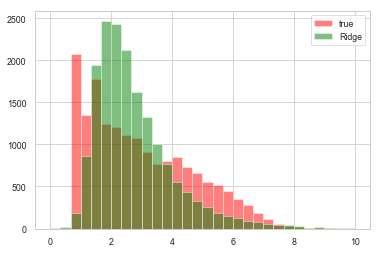

In [104]:
print('Ridge valid mae: {}'.format(ridge_experiment['valid_mae']))

plt.hist(y_valid, bins=30, alpha=.5, color='red', label='true', range=(0,10));
plt.hist(ridge_pred, bins=30, alpha=.5, color='green', label='Ridge', range=(0,10));
plt.legend();

In [105]:
lgm, lgb_pred, lgm_experiment, lgm_test_pred = train_lgm(
        X_train_part,
        y_train_part,
        X_valid,
        y_valid,
        X_test_new)
lgb_pred1 = pred_to_src(lgm.predict(X_train_part))
print('LGM valid mae: {}'.format(lgm_experiment['valid_mae']))

(39987, 60315)
[1]	valid_0's l1: 0.381775
Training until validation scores don't improve for 20 rounds.
[2]	valid_0's l1: 0.375704
[3]	valid_0's l1: 0.370601
[4]	valid_0's l1: 0.366424
[5]	valid_0's l1: 0.362416
[6]	valid_0's l1: 0.358914
[7]	valid_0's l1: 0.355953
[8]	valid_0's l1: 0.353342
[9]	valid_0's l1: 0.351193
[10]	valid_0's l1: 0.349128
[11]	valid_0's l1: 0.34728
[12]	valid_0's l1: 0.345294
[13]	valid_0's l1: 0.343706
[14]	valid_0's l1: 0.342464
[15]	valid_0's l1: 0.341168
[16]	valid_0's l1: 0.340208
[17]	valid_0's l1: 0.338749
[18]	valid_0's l1: 0.337708
[19]	valid_0's l1: 0.336779
[20]	valid_0's l1: 0.336102
[21]	valid_0's l1: 0.335453
[22]	valid_0's l1: 0.334835
[23]	valid_0's l1: 0.333873
[24]	valid_0's l1: 0.333243
[25]	valid_0's l1: 0.332697
[26]	valid_0's l1: 0.332067
[27]	valid_0's l1: 0.331456
[28]	valid_0's l1: 0.330816
[29]	valid_0's l1: 0.330333
[30]	valid_0's l1: 0.329918
[31]	valid_0's l1: 0.329271
[32]	valid_0's l1: 0.328735
[33]	valid_0's l1: 0.328403
[34]	vali

[286]	valid_0's l1: 0.310387
[287]	valid_0's l1: 0.310382
[288]	valid_0's l1: 0.31039
[289]	valid_0's l1: 0.310373
[290]	valid_0's l1: 0.310398
[291]	valid_0's l1: 0.310396
[292]	valid_0's l1: 0.310404
[293]	valid_0's l1: 0.310408
[294]	valid_0's l1: 0.310363
[295]	valid_0's l1: 0.310354
[296]	valid_0's l1: 0.310339
[297]	valid_0's l1: 0.310344
[298]	valid_0's l1: 0.310335
[299]	valid_0's l1: 0.310345
[300]	valid_0's l1: 0.310328
[301]	valid_0's l1: 0.310317
[302]	valid_0's l1: 0.310309
[303]	valid_0's l1: 0.310286
[304]	valid_0's l1: 0.310286
[305]	valid_0's l1: 0.310281
[306]	valid_0's l1: 0.310308
[307]	valid_0's l1: 0.310268
[308]	valid_0's l1: 0.310255
[309]	valid_0's l1: 0.310268
[310]	valid_0's l1: 0.310266
[311]	valid_0's l1: 0.310265
[312]	valid_0's l1: 0.310265
[313]	valid_0's l1: 0.310241
[314]	valid_0's l1: 0.310232
[315]	valid_0's l1: 0.310244
[316]	valid_0's l1: 0.310236
[317]	valid_0's l1: 0.310223
[318]	valid_0's l1: 0.310209
[319]	valid_0's l1: 0.310211
[320]	valid_0's

LGM valid mae: 1.1415809589855845


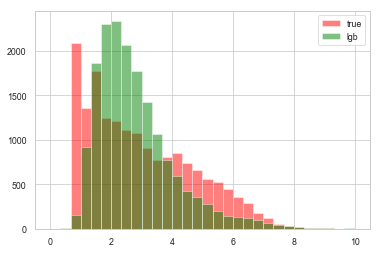

In [106]:
print('LGM valid mae: {}'.format(lgm_experiment['valid_mae']))
plt.hist(y_valid, bins=30, alpha=.5, color='red', label='true', range=(0,10));
plt.hist(lgb_pred, bins=30, alpha=.5, color='green', label='lgb', range=(0,10));
plt.legend();

LGM valid mae: 1.1427492959135814
Ridge valid mae: 1.0779352274080007
Mix valid mae: 1.081475528598624


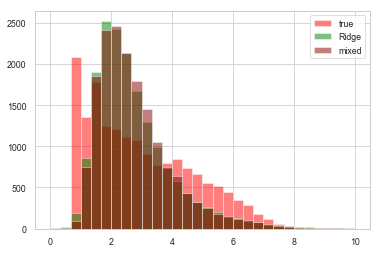

In [30]:
coef_1 = 0.6
coef_2 = 0.4

mix_pred = coef_1 * lgb_pred + coef_2 * ridge_pred
#mix_pred = coef_1 * sgd_pred + coef_2 * ridge_pred
#mix_pred = coef_1 * lgb_pred + coef_2 * ridge_pred
#mix_pred = np.expm1(coef_1 * 1/(lgb_pred**(-2)) + coef_2 * 1/(ridge_pred**(-2)))

print('LGM valid mae: {}'.format(lgm_experiment['valid_mae']))
print('Ridge valid mae: {}'.format(ridge_experiment['valid_mae']))
#print('SGD valid mae: {}'.format(sgd_experiment['valid_mae']))
print('Mix valid mae: {}'.format(mean_absolute_error(y_valid, mix_pred)))

plt.hist(y_valid, bins=30, alpha=.5, color='red', label='true', range=(0,10));
#plt.hist(np.log2(1+y_valid), bins=30, alpha=.5, color='gray', label='true', range=(0,10));
plt.hist(ridge_pred, bins=30, alpha=.5, color='green', label='Ridge', range=(0,10));
plt.hist(mix_pred, bins=30, alpha=.5, color='maroon', label='mixed', range=(0,10));
plt.legend();

In [107]:
lgm_experiment, ridge_experiment

({'time': 'train_lgm14_11_2018_08_56_54',
  'transformed_train_df_shape': (39987, 60315),
  'features': ['author_tfidf',
   'domain_tfidf',
   'weekday_cat',
   'month_cat',
   'hour_val',
   'content_lemma_tfidf'],
  'clf': 'lgm',
  'valid_mae': 1.1415809589855845,
  'np.expm1_valid_mae': 2.1317155673603709},
 {'time': 'train_ridge14_11_2018_08_56_39',
  'transformed_train_df_shape': (39987, 60315),
  'features': ['author_tfidf',
   'domain_tfidf',
   'weekday_cat',
   'month_cat',
   'hour_val',
   'content_lemma_tfidf'],
  'clf': 'train_ridge',
  'valid_mae': 1.0781211630073593,
  'np.expm1_valid_mae': 1.9391521723413025})

In [36]:
experiments[lgm_experiment['time']] = lgm_experiment
experiments[ridge_experiment['time']] = ridge_experiment

with open('medium_experiments.pickle', 'wb') as f:
    pickle.dump(experiments, f)

In [41]:
ridge, ridge_full_pred = full_fit(ridge, X_train_new, y_train_new, X_test_new)
lgm, lgm_full_pred = full_lgm_fit(lgm, X_train_new, y_train_new, X_test_new)

mix_full_pred = coef_1 * lgm_full_pred + coef_2 * ridge_full_pred

# ==> predict
full_pred_corrected = \
    mix_full_pred + (all_zero_mae - mix_full_pred.mean())
write_submission_file(prediction=full_pred_corrected,
                      filename=experiment['submission_file'])
# <== predict

In [172]:
print(lgm_experiment)
print(ridge_experiment)
# ==> 1.47182

{'time': 'train_lgm14_11_2018_12_23_23', 'transformed_train_df_shape': (39987, 60317), 'features': ['author_tfidf', 'domain_tfidf', 'weekday_cat', 'month_cat', 'hour_val', 'kmeans_class', 'content_lemma_tfidf'], 'clf': 'lgm', 'valid_mae': 1.149258180673097, 'np.expm1_valid_mae': 2.1558509699067652}
{'time': 'train_ridge14_11_2018_12_22_38', 'transformed_train_df_shape': (39987, 60317), 'features': ['author_tfidf', 'domain_tfidf', 'weekday_cat', 'month_cat', 'hour_val', 'kmeans_class', 'content_lemma_tfidf'], 'clf': 'train_ridge', 'valid_mae': 1.0510040028104572, 'np.expm1_valid_mae': 1.8605216485862321}


In [162]:
type(transformed_test_df)

scipy.sparse.coo.coo_matrix

In [147]:
transformed_train_df = hstack([transformed_train_df, kmeans.predict(transformed_train_df).reshape(-1, 1)])
transformed_train_df.shape

(57125, 60316)

In [148]:
transformed_test_df = hstack([transformed_test_df, kmeans.predict(transformed_test_df).reshape(-1, 1)])
transformed_test_df.shape

(34645, 60316)

In [161]:
kmeans = KMeans(n_clusters=10, random_state=17).fit(X_train_new)
# x_train_new['kmean_class'] = kmeans.predict(x_train_new)
# x_test_new['kmean_class'] = kmeans.predict(x_test_new)

In [163]:
experiment_name = time.strftime("%d_%m_%Y_%H_%M_%S")
experiment = {}
experiment['time'] = experiment_name
experiment['submission_file'] = experiment['time'] + '.csv'

# transformed_train_df = transform_pipeline.fit_transform(x_train_new)
# transformed_test_df = transform_pipeline.transform(x_test_new)

transformed_train_df = hstack([transformed_train_df, kmeans.predict(transformed_train_df).reshape(-1, 1)])
transformed_test_df = hstack([transformed_test_df, kmeans.predict(transformed_test_df).reshape(-1, 1)])

In [167]:
X_train_new = transformed_train_df
y_train_new = train_df['target']
X_test_new = transformed_test_df

print(transformed_train_df.shape, transformed_test_df.shape)

experiment['transformed_train_df_shape'] = transformed_train_df.shape
experiment['transformed_test_df_shape'] = transformed_test_df.shape
experiment['features'] = [v[0] for v in transform_pipeline.steps[0][1].transformer_list]

X_train_part, X_valid, y_train_part, y_valid = \
        train_test_split(
                X_train_new,
                y_train_new,
                test_size=0.3,
                random_state=17)

(57125, 60317) (34645, 60317)


In [168]:
# train ridge
ridge, ridge_pred, ridge_experiment, ridge_test_pred = train_ridge(
        X_train_part,
        y_train_part,
        X_valid,
        y_valid,
        X_test_new)
ridge_pred1 = pred_to_src(ridge.predict(X_train_part))

print('Ridge valid mae: {}'.format(ridge_experiment['valid_mae']))

(39987, 60317)
train_ridge valid mae: 1.0510040028104572
Ridge valid mae: 1.0510040028104572


In [169]:
lgm, lgb_pred, lgm_experiment, lgm_test_pred = train_lgm(
        X_train_part,
        y_train_part,
        X_valid,
        y_valid,
        X_test_new)
lgb_pred1 = pred_to_src(lgm.predict(X_train_part))
print('LGM valid mae: {}'.format(lgm_experiment['valid_mae']))

(39987, 60317)
[1]	valid_0's l1: 0.403439
Training until validation scores don't improve for 20 rounds.
[2]	valid_0's l1: 0.396547
[3]	valid_0's l1: 0.390486
[4]	valid_0's l1: 0.38495
[5]	valid_0's l1: 0.380079
[6]	valid_0's l1: 0.375757
[7]	valid_0's l1: 0.371964
[8]	valid_0's l1: 0.368131
[9]	valid_0's l1: 0.364617
[10]	valid_0's l1: 0.361655
[11]	valid_0's l1: 0.359055
[12]	valid_0's l1: 0.356879
[13]	valid_0's l1: 0.354723
[14]	valid_0's l1: 0.352727
[15]	valid_0's l1: 0.351037
[16]	valid_0's l1: 0.349456
[17]	valid_0's l1: 0.347467
[18]	valid_0's l1: 0.346162
[19]	valid_0's l1: 0.344926
[20]	valid_0's l1: 0.343493
[21]	valid_0's l1: 0.342476
[22]	valid_0's l1: 0.341536
[23]	valid_0's l1: 0.340607
[24]	valid_0's l1: 0.339469
[25]	valid_0's l1: 0.338037
[26]	valid_0's l1: 0.337226
[27]	valid_0's l1: 0.336416
[28]	valid_0's l1: 0.335527
[29]	valid_0's l1: 0.334709
[30]	valid_0's l1: 0.333979
[31]	valid_0's l1: 0.333194
[32]	valid_0's l1: 0.332208
[33]	valid_0's l1: 0.331489
[34]	vali

[286]	valid_0's l1: 0.306618
[287]	valid_0's l1: 0.306607
[288]	valid_0's l1: 0.306619
[289]	valid_0's l1: 0.306625
[290]	valid_0's l1: 0.306639
[291]	valid_0's l1: 0.306617
[292]	valid_0's l1: 0.306577
[293]	valid_0's l1: 0.306556
[294]	valid_0's l1: 0.306534
[295]	valid_0's l1: 0.306521
[296]	valid_0's l1: 0.306513
[297]	valid_0's l1: 0.306522
[298]	valid_0's l1: 0.306503
[299]	valid_0's l1: 0.306484
[300]	valid_0's l1: 0.306456
[301]	valid_0's l1: 0.306447
[302]	valid_0's l1: 0.306436
[303]	valid_0's l1: 0.306423
[304]	valid_0's l1: 0.306421
[305]	valid_0's l1: 0.306426
[306]	valid_0's l1: 0.306409
[307]	valid_0's l1: 0.306395
[308]	valid_0's l1: 0.306399
[309]	valid_0's l1: 0.306358
[310]	valid_0's l1: 0.306368
[311]	valid_0's l1: 0.306348
[312]	valid_0's l1: 0.306343
[313]	valid_0's l1: 0.306325
[314]	valid_0's l1: 0.306322
[315]	valid_0's l1: 0.30631
[316]	valid_0's l1: 0.306294
[317]	valid_0's l1: 0.306288
[318]	valid_0's l1: 0.306287
[319]	valid_0's l1: 0.306258
[320]	valid_0's

LGM valid mae: 1.149258180673097
Ridge valid mae: 1.0510040028104572
Mix valid mae: 1.073230587289193


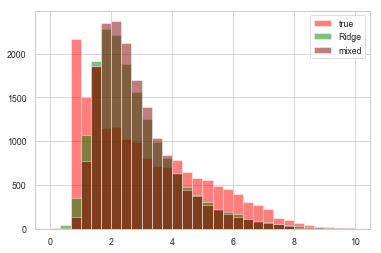

In [170]:
coef_1 = 0.6
coef_2 = 0.4

mix_pred = coef_1 * lgb_pred + coef_2 * ridge_pred
#mix_pred = coef_1 * sgd_pred + coef_2 * ridge_pred
#mix_pred = coef_1 * lgb_pred + coef_2 * ridge_pred
#mix_pred = np.expm1(coef_1 * 1/(lgb_pred**(-2)) + coef_2 * 1/(ridge_pred**(-2)))

print('LGM valid mae: {}'.format(lgm_experiment['valid_mae']))
print('Ridge valid mae: {}'.format(ridge_experiment['valid_mae']))
#print('SGD valid mae: {}'.format(sgd_experiment['valid_mae']))
print('Mix valid mae: {}'.format(mean_absolute_error(y_valid, mix_pred)))

plt.hist(y_valid, bins=30, alpha=.5, color='red', label='true', range=(0,10));
#plt.hist(np.log2(1+y_valid), bins=30, alpha=.5, color='gray', label='true', range=(0,10));
plt.hist(ridge_pred, bins=30, alpha=.5, color='green', label='Ridge', range=(0,10));
plt.hist(mix_pred, bins=30, alpha=.5, color='maroon', label='mixed', range=(0,10));
plt.legend();

In [171]:
ridge, ridge_full_pred = full_fit(ridge, X_train_new, y_train_new, X_test_new)
lgm, lgm_full_pred = full_lgm_fit(lgm, X_train_new, y_train_new, X_test_new)

mix_full_pred = coef_1 * lgm_full_pred + coef_2 * ridge_full_pred

# ==> predict
full_pred_corrected = \
    mix_full_pred + (all_zero_mae - mix_full_pred.mean())
write_submission_file(prediction=full_pred_corrected,
                      filename=experiment['submission_file'])
# <== predict